Name: Vyshnavi Kundula

In [30]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [31]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/plant_disease.v795i.yolov9.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [32]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [33]:
import os
import zipfile

# Path to the ZIP file
zip_file_path = '/content/drive/MyDrive/plant_disease.v795i.yolov9.zip'

# Directory to extract the files
extracted_dir = 'extracted_dataset'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Use the extracted directory for image_dataset_from_directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    extracted_dir,
    seed=123,
    shuffle=True,
    image_size=(256, 256),
    batch_size=256)


Found 3943 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['test', 'train', 'valid']

In [35]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(256, 256, 256, 3)
[2 1 1 1 1 2 1 2 1 1 1 1 2 2 1 1 1 1 1 0 1 1 2 2 1 0 1 1 1 0 1 1 1 2 1 1 1
 1 1 1 1 0 1 1 1 2 2 1 0 1 2 1 1 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 2 1 2 1 1 2 1 2 1 1 0 1 1 1 1
 1 1 1 1 1 2 1 1 1 1 1 2 0 1 1 1 2 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1
 2 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 2 1 1 1 0 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 2 1 1 2 2 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 2 1 1 1 1 1 1 1 2 1 1 0 1 1 1 1]


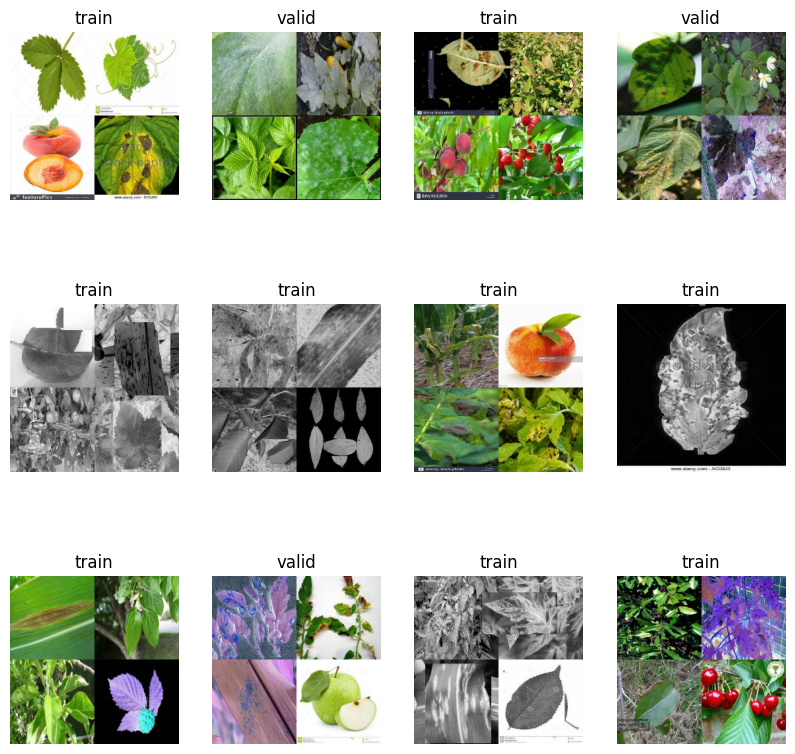

In [36]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [37]:
len(dataset)

16

In [38]:
train_size = 0.8
len(dataset)*train_size

12.8

In [39]:
train_ds = dataset.take(54)
len(train_ds)

16

In [40]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [41]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [42]:
val_ds = test_ds.take(6)
len(val_ds)

0

In [43]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [46]:
len(train_ds)

12

In [47]:
len(val_ds)

1

In [48]:
len(test_ds)

3

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [51]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [52]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [55]:
from tensorflow.keras import Model

In [56]:
xs

In [57]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
12/12 [==============================] - 71s 4s/step - loss: 0.7088 - accuracy: 0.7985 - val_loss: 0.6109 - val_accuracy: 0.8203
Epoch 2/30
12/12 [==============================] - 32s 3s/step - loss: 0.6189 - accuracy: 0.8239 - val_loss: 0.6125 - val_accuracy: 0.8203
Epoch 3/30
12/12 [==============================] - 31s 3s/step - loss: 0.5960 - accuracy: 0.8239 - val_loss: 0.6095 - val_accuracy: 0.8203
Epoch 4/30
12/12 [==============================] - 31s 3s/step - loss: 0.5872 - accuracy: 0.8239 - val_loss: 0.6106 - val_accuracy: 0.8203
Epoch 5/30
12/12 [==============================] - 31s 3s/step - loss: 0.5880 - accuracy: 0.8239 - val_loss: 0.6121 - val_accuracy: 0.8203
Epoch 6/30
12/12 [==============================] - 30s 3s/step - loss: 0.5875 - accuracy: 0.8239 - val_loss: 0.6215 - val_accuracy: 0.8203
Epoch 7/30
12/12 [==============================] - 31s 3s/step - loss: 0.5911 - accuracy: 0.8239 - val_loss: 0.6121 - val_accuracy: 0.8203
Epoch 8/30
12/12 [==